# Question 1


1. Create a recurrent neural network in TensorFlow to predict the operating mode of a wind turbine based on the two time series from the sensors. Before any implementation, carefully consider what type of approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to manipulate the data, given that you have two different time series for each observation. Then, make sure that you try out the different layers and elements discussed in class, such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be necessary, it is recommended that you tune your network systematically. Make sure to record your final validation set accuracy.

In [2]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Input, Dropout, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras import backend as K

In [ ]:
with open('time_series_1.pickle', 'rb') as handle:
  time_series_1 = pickle.load(handle)
with open('time_series_2.pickle', 'rb') as handle:
  time_series_2 = pickle.load(handle)  
with open('y.pickle', 'rb') as handle:
  y = pickle.load(handle)

In [ ]:
print(type(time_series_1))
print(type(time_series_2))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(time_series_1.shape)
print(time_series_2.shape)
print(y.shape)

(4000, 5000)
(4000, 5000)
(4000,)


Combining the timeseries

In [ ]:
Timeseries_combined = np.dstack((time_series_1,time_series_2))

In [ ]:
print(Timeseries_combined.shape)

(4000, 5000, 2)


In [ ]:
Y = np.reshape(y, (4000, 1))

In [ ]:
print(Y.shape)

(4000, 1)


Splitting into test, train and validation sets

In [ ]:
X_train, X_test_1, y_train, y_test_1 = train_test_split(Timeseries_combined,Y,test_size = 0.3, random_state = 704)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test_1, y_test_1,test_size = 0.5, random_state = 704)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2800, 5000, 2)
(600, 5000, 2)
(600, 5000, 2)


####Defining the model

In [ ]:
def train_plot(model, learning_rate = 0.001, epochs = 15):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
    
    return model

####Simple RNN 

In [ ]:
model = Sequential([
    SimpleRNN(70, return_sequences=False, input_shape=[None, 2]),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 70)                5110      
                                                                 
 dense_1 (Dense)             (None, 5)                 355       
                                                                 
Total params: 5,465
Trainable params: 5,465
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 272s 3s/step - loss: 1.4040 - accuracy: 0.3121 - val_loss: 1.3113 - val_accuracy: 0.3400
Epoch 2/15
88/88 [==============================] - 269s 3s/step - loss: 1.3168 - accuracy: 0.3818 - val_loss: 1.3008 - val_accuracy: 0.3800
Epoch 3/15
88/88 [==============================] - 268s 3s/step - loss: 1.2938 - accuracy: 0.3975 - val_loss: 1.3001 - val_accuracy: 0.3933
Epoch 4/15
88/88 [==============================] - 267s 3s/step - loss: 1.2769 - accuracy: 0.4104 - val_loss: 1.2430 - val_accuracy: 0.3983
Epoch 5/15
88/88 [==============================] - 270s 3s/step - loss: 1.2234 - accuracy: 0.4421 - val_loss: 1.1672 - val_accuracy: 0.4650
Epoch 6/15
88/88 [==============================] - 268s 3s/step - loss: 1.1659 - accuracy: 0.4957 - val_loss: 1.1540 - val_accuracy: 0.4900
Epoch 7/15
88/88 [==============================] - 264s 3s/step - loss: 1.1377 - accuracy: 0.5107 - val_loss: 1.1029 - val_accuracy: 0.5000
Epoch 8/15
88

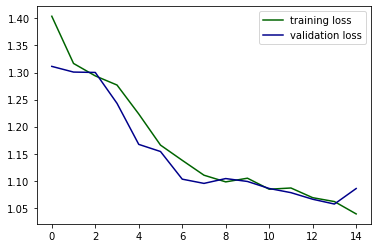

In [ ]:
train_plot(model)

The accuracy of the simple RNN is poor, and is showing signs of overfitting, however a deeper one may be more accurate

####Deeper RNN

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [ ]:
model = Sequential([
    SimpleRNN(70, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(50, return_sequences=False),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 70)          5110      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                6050      
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 11,415
Trainable params: 11,415
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 354s 4s/step - loss: 1.3944 - accuracy: 0.2832 - val_loss: 1.3075 - val_accuracy: 0.3200
Epoch 2/15
88/88 [==============================] - 355s 4s/step - loss: 1.3009 - accuracy: 0.3961 - val_loss: 1.2631 - val_accuracy: 0.4000
Epoch 3/15
88/88 [==============================] - 357s 4s/step - loss: 1.2490 - accuracy: 0.4271 - val_loss: 1.2456 - val_accuracy: 0.4467
Epoch 4/15
88/88 [==============================] - 356s 4s/step - loss: 1.1709 - accuracy: 0.4775 - val_loss: 1.0855 - val_accuracy: 0.4967
Epoch 5/15
88/88 [==============================] - 352s 4s/step - loss: 1.0670 - accuracy: 0.5393 - val_loss: 1.0039 - val_accuracy: 0.5567
Epoch 6/15
88/88 [==============================] - 353s 4s/step - loss: 1.0082 - accuracy: 0.5596 - val_loss: 0.9368 - val_accuracy: 0.5800
Epoch 7/15
88/88 [==============================] - 352s 4s/step - loss: 0.9187 - accuracy: 0.6121 - val_loss: 0.9477 - val_accuracy: 0.5767
Epoch 8/15
88

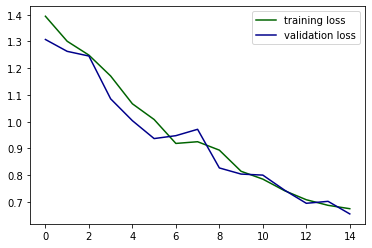

In [ ]:
train_plot(model)

The deeper RNN has a good validation accuracy of 76%, however it is too computationally intensive to use for that level of accuracy.  

####Long Short Term Memory (LSTM)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=[None, 2]),
    LSTM(50, return_sequences = False),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 31,310
Trainable params: 31,310
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 530s 6s/step - loss: 1.4899 - accuracy: 0.2807 - val_loss: 1.3696 - val_accuracy: 0.3183
Epoch 2/15
88/88 [==============================] - 526s 6s/step - loss: 1.3621 - accuracy: 0.3171 - val_loss: 1.3359 - val_accuracy: 0.3667
Epoch 3/15
88/88 [==============================] - 527s 6s/step - loss: 1.3329 - accuracy: 0.3611 - val_loss: 1.3322 - val_accuracy: 0.4017
Epoch 4/15
88/88 [==============================] - 522s 6s/step - loss: 1.3280 - accuracy: 0.3650 - val_loss: 1.3072 - val_accuracy: 0.3117
Epoch 5/15
88/88 [==============================] - 521s 6s/step - loss: 1.3164 - accuracy: 0.3711 - val_loss: 1.2840 - val_accuracy: 0.3983
Epoch 6/15
88/88 [==============================] - 523s 6s/step - loss: 1.2971 - accuracy: 0.3993 - val_loss: 1.2757 - val_accuracy: 0.3700
Epoch 7/15
88/88 [==============================] - 526s 6s/step - loss: 1.2822 - accuracy: 0.4168 - val_loss: 1.2574 - val_accuracy: 0.3783
Epoch 8/15
88

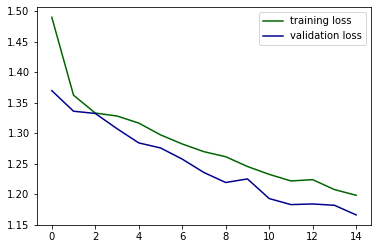

In [ ]:
train_plot(model)

LSTM networks were designed to be capable of learning long-term dependencies. However, in this case, the validation accuracy is only 46%, and seems to be tending towards overfitting. Moreover, the amount of time taken per epoch means it is unfeasible to use.

####Gated Recurrent Units (GRU)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [ ]:
model = Sequential([
    GRU(200, return_sequences=True, input_shape=[None, 2]),
    GRU(30, return_sequences= True),
    GRU(30, return_sequences = False),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 200)         122400    
                                                                 
 gru_1 (GRU)                 (None, None, 30)          20880     
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense (Dense)               (None, 10)                310       
                                                                 
Total params: 149,170
Trainable params: 149,170
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 1148s 13s/step - loss: 1.4884 - accuracy: 0.2621 - val_loss: 1.3972 - val_accuracy: 0.2900
Epoch 2/15
88/88 [==============================] - 1121s 13s/step - loss: 1.3435 - accuracy: 0.3571 - val_loss: 1.2623 - val_accuracy: 0.4467
Epoch 3/15
88/88 [==============================] - 1134s 13s/step - loss: 1.1749 - accuracy: 0.5079 - val_loss: 1.0509 - val_accuracy: 0.5267
Epoch 4/15
88/88 [==============================] - 1132s 13s/step - loss: 0.9737 - accuracy: 0.6004 - val_loss: 0.8768 - val_accuracy: 0.5800
Epoch 5/15
88/88 [==============================] - 1130s 13s/step - loss: 0.8012 - accuracy: 0.6843 - val_loss: 0.6930 - val_accuracy: 0.7217
Epoch 6/15
88/88 [==============================] - 1133s 13s/step - loss: 0.6771 - accuracy: 0.7307 - val_loss: 0.5941 - val_accuracy: 0.7650
Epoch 7/15
88/88 [==============================] - 1135s 13s/step - loss: 0.5824 - accuracy: 0.7704 - val_loss: 0.5577 - val_accuracy: 0.7100

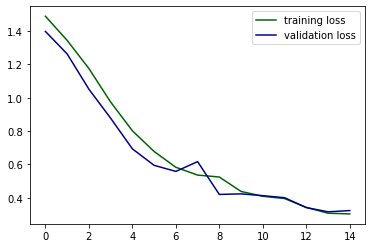

In [ ]:
train_plot(model)

The GRU network was very computationally intensive, taking twice the time of the LSTM network, however shoed very promising results, with a validation acuracy of 86.33%. The graph however shows there may be chances of overfitting occurring with more epochs.

####1Dimensional Convolutional Layer (Conv1D)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [ ]:
model = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]),
    SimpleRNN(50, return_sequences=False),
    Dense(15, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                3550      
                                                                 
 dense (Dense)               (None, 15)                765       
                                                                 
Total params: 4,495
Trainable params: 4,495
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 241s 3s/step - loss: 1.5261 - accuracy: 0.3668 - val_loss: 1.2903 - val_accuracy: 0.3917
Epoch 2/15
88/88 [==============================] - 237s 3s/step - loss: 1.2702 - accuracy: 0.4439 - val_loss: 1.2125 - val_accuracy: 0.4733
Epoch 3/15
88/88 [==============================] - 239s 3s/step - loss: 1.2082 - accuracy: 0.4675 - val_loss: 1.1922 - val_accuracy: 0.4817
Epoch 4/15
88/88 [==============================] - 239s 3s/step - loss: 1.1868 - accuracy: 0.4889 - val_loss: 1.1567 - val_accuracy: 0.4833
Epoch 5/15
88/88 [==============================] - 236s 3s/step - loss: 1.1594 - accuracy: 0.4911 - val_loss: 1.1201 - val_accuracy: 0.4900
Epoch 6/15
88/88 [==============================] - 236s 3s/step - loss: 1.1353 - accuracy: 0.5057 - val_loss: 1.0785 - val_accuracy: 0.5267
Epoch 7/15
88/88 [==============================] - 237s 3s/step - loss: 1.1163 - accuracy: 0.5214 - val_loss: 1.0692 - val_accuracy: 0.5267
Epoch 8/15
88

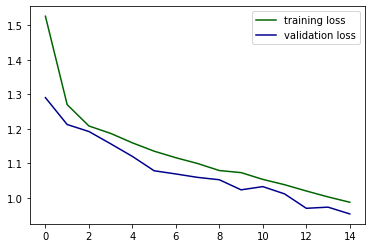

In [ ]:
train_plot(model)

The Conv1D network showed poor accuracy, however was comparitively fast. In spite of the speed, poor accuracy means this model is unfeasible. 

# Question 2

Another tool for analyzing time-series data is convolutional neural networks with 2D convolutional layers. For this to work, time series need to be converted into “images” (matrices of numbers). The paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library) describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections 
4 and 5 that depict the process of converting one or multiple time series into “images” used within a CNN.

In your own words, explain why the approach outlined here can help analyze time-series 
data and why it might outperform RNNs

##### Answer

A Convolutional Neural Network (CNN) structure consists of 3 parts, namely the convolutional layer, the pooling layer and the fully connected layer. The convolutional layer is similar to a neural network, where each neuron is connected to a bunch of neurons in a previous layer. The kernel is a part of this layer, that act like matrices of the filters of the convolutional layer. The pooling layer will reduce the sampling rate of the input, to prevent overfitting and reduce dimension of the space. Finally, the fully connected neural network, is used to classify, or regress in supervised learning. 
Time series signals can be converted into 2-D images, through filling each row of an image matrix step-by-step with the time series data. A CNN will gather information through analysis of individual pixels relationships with their neighbours, which means neighbouring pixels should have a very similar correlation with the exception of faulty ones. Working with time-series signals is extremely difficult, hence conversion of the raw-data into a 2D greyscale image is a very important pre-processing step. The paper tried multiple methods, and the conclusion reached by the authors was that the addition of a convolutional layer increased the accuracy of both the training and validation. The CNN’s were able to classify even the smallest of faults and anomalies in the presence of noise, and adding the convolutional layer increased accuracy to 96.2% in 5000 records. 

Upon doing further research, it also seems that CNNs are computationally cheaper than RNNs; they don’t require a complete history as they only learn patterns within a time period and can also see the data from a broader perspective (Convolutional Neural Network (CNN) for Time Series Classification - スマートファクトリー - マクニカ, 2020).

# Question 3 

Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18 convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray-scale image).


In [4]:
with open('time_series_1.pickle', 'rb') as handle:
  time_series_1_3 = pickle.load(handle)
with open('time_series_2.pickle', 'rb') as handle:
  time_series_2_3 = pickle.load(handle)  
with open('y.pickle', 'rb') as handle:
  y_pickle2 = pickle.load(handle)

In [5]:
TimeSeries_combined_Q3 = np.hstack((time_series_1_3, time_series_2_3))

In [6]:
TimeSeries_combined_Q3.shape

(4000, 10000)

Splitting into test, train and validation

In [7]:
X_train_Q3, X_test_1_Q3, y_train_Q3, y_test_1_Q3 = train_test_split(TimeSeries_combined_Q3,y_pickle2,test_size = 0.3, random_state = 704)

In [8]:
X_test_Q3, X_val_Q3, y_test_Q3, y_val_Q3 = train_test_split(X_test_1_Q3, y_test_1_Q3,test_size = 0.5, random_state = 704)

Changing type

In [9]:
X_train_Q3 = X_train_Q3.astype('float32')
X_val_Q3 = X_val_Q3.astype('float32')
X_test_Q3 = X_test_Q3.astype('float32')

In [10]:
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1

One-hot encoding

In [11]:
y_train_Q3 = tf.keras.utils.to_categorical(y_train_Q3, num_classes)
y_val_Q3 = tf.keras.utils.to_categorical(y_val_Q3, num_classes)
y_test_Q3 = tf.keras.utils.to_categorical(y_test_Q3, num_classes)

Reshaping to a (100,100,1) image

In [12]:
if K.image_data_format() == 'channels_first':
  X_train_Q3 = X_train_Q3.reshape(X_train_Q3.shape[0], img_channels, img_rows, img_cols)
  X_val_Q3 = X_val_Q3.reshape(X_val_Q3.shape[0], img_channels, img_rows, img_cols)
  X_test_Q3 = X_test_Q3.reshape(X_test_Q3.shape[0], img_channels, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
else:
  X_train_Q3 = X_train_Q3.reshape(X_train_Q3.shape[0], img_rows, img_cols, img_channels)
  X_val_Q3 = X_val_Q3.reshape(X_val_Q3.shape[0], img_rows, img_cols, img_channels)
  X_test_Q3 = X_test_Q3.reshape(X_test_Q3.shape[0], img_rows, img_cols, img_channels)
  input_shape = (img_rows, img_cols, img_channels)

# Question 4


In TensorFlow, replicate the CNN with two convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy. (Figure 12 has 3 layers, so that CNN was made)
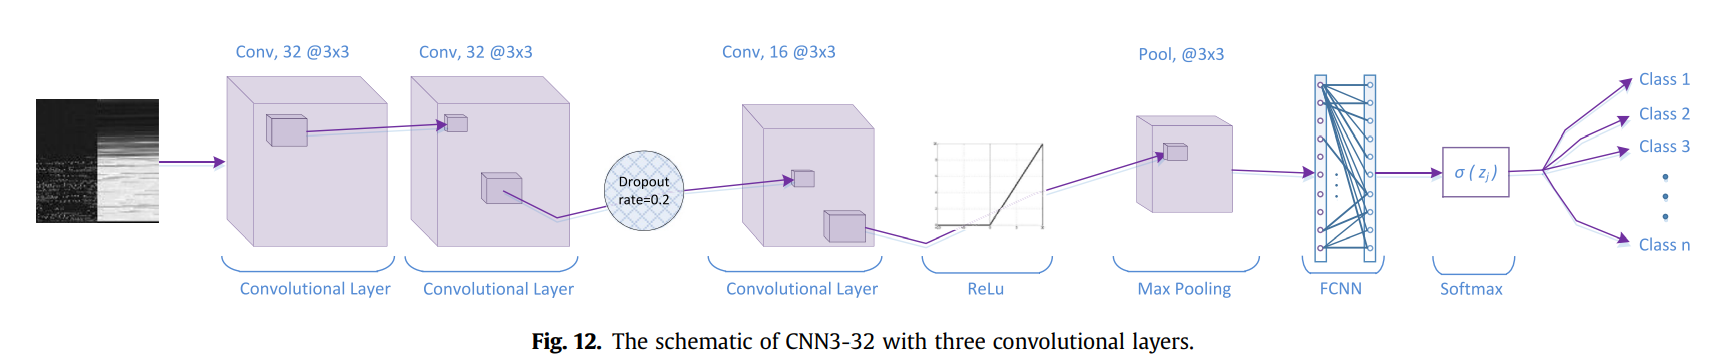

#####Training function for convolutional neural networks

In [25]:
def train_plot(modelCNN, learning_rate = 0.001, epochs = 30):
    np.random.seed(312)
    tf.random.set_seed(312)

    modelCNN.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=Adam(learning_rate = learning_rate),metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = modelCNN.fit(X_train_Q3, y_train_Q3, epochs=epochs,
                        validation_data=(X_val_Q3, y_val_Q3),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='deeppink')
    plt.plot(log.history['val_loss'], label = "validation loss",color='turquoise')
    plt.legend()
    plt.show()
    
    y_pred = modelCNN.predict(X_val_Q3)
    
    return modelCNN

In [26]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [27]:
modelCNN = Sequential([
                       Conv2D(32, kernel_size=(3,3), input_shape = input_shape),
                       Conv2D(32, kernel_size=(3,3)),
                       Dropout(0.2),
                       Conv2D(16, kernel_size=(3,3), activation='relu'),
                       MaxPooling2D(pool_size=(3,3)),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                        

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 2s 14ms/step - loss: 14.2059 - accuracy: 0.2850 - val_loss: 1.3865 - val_accuracy: 0.2517
Epoch 2/30
88/88 [==============================] - 1s 11ms/step - loss: 1.1938 - accuracy: 0.4589 - val_loss: 0.6890 - val_accuracy: 0.8150
Epoch 3/30
88/88 [==============================] - 1s 11ms/step - loss: 0.4374 - accuracy: 0.8393 - val_loss: 0.2781 - val_accuracy: 0.8917
Epoch 4/30
88/88 [==============================] - 1s 11ms/step - loss: 0.3341 - accuracy: 0.8768 - val_loss: 0.2736 - val_accuracy: 0.8667
Epoch 5/30
88/88 [==============================] - 1s 11ms/step - loss: 0.2856 - accuracy: 0.8775 - val_loss: 0.2343 - val_accuracy: 0.9017
Epoch 6/30
88/88 [==============================] - 1s 11ms/step - loss: 0.2843 - accuracy: 0.8829 - val_loss: 0.2410 - val_accuracy: 0.9000
Epoch 7/30
88/88 [==============================] - 1s 11ms/step - loss: 0.2700 - accuracy: 0.8850 - val_loss: 0.2330 - val_accuracy: 0.8750
Epoch 8/30
88/88 [=====

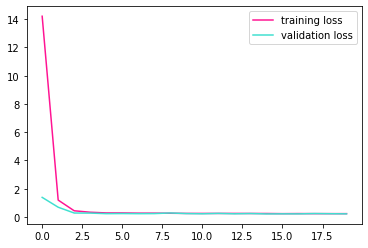

In [28]:
train_plot(modelCNN)

The model from the paper showed an excellent result, with a validation accuracy of 89.17%, It was also incredibly quick, with 20 epochs taking approximately 20 seconds. 

# Question 5

Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.

####CNN4-128

This model was 4 2d convolutional layers, with batch normalisation in each level; however no max pooling layer was included. 

In [30]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [31]:
modelCNN = Sequential([
                       Conv2D(128, kernel_size=(3,3), input_shape = input_shape),
                       BatchNormalization(),
                       Conv2D(64, kernel_size=(3,3)),
                       BatchNormalization(),
                       Dropout(0.2),
                       Conv2D(32, kernel_size=(3,3), activation='relu'),
                       Conv2D(16, kernel_size=(3,3)),
                       BatchNormalization(),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 96, 96, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        1

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 4s 39ms/step - loss: 7.3638 - accuracy: 0.7271 - val_loss: 5.6775 - val_accuracy: 0.7417
Epoch 2/30
88/88 [==============================] - 3s 36ms/step - loss: 2.3463 - accuracy: 0.8607 - val_loss: 3.6402 - val_accuracy: 0.7683
Epoch 3/30
88/88 [==============================] - 3s 36ms/step - loss: 3.4606 - accuracy: 0.8621 - val_loss: 5.6757 - val_accuracy: 0.8600
Epoch 4/30
88/88 [==============================] - 3s 36ms/step - loss: 2.4834 - accuracy: 0.8682 - val_loss: 0.9209 - val_accuracy: 0.8450
Epoch 5/30
88/88 [==============================] - 3s 36ms/step - loss: 1.8584 - accuracy: 0.8779 - val_loss: 2.3344 - val_accuracy: 0.7650
Epoch 6/30
88/88 [==============================] - 3s 36ms/step - loss: 1.9930 - accuracy: 0.8725 - val_loss: 1.7498 - val_accuracy: 0.8767
Epoch 7/30
88/88 [==============================] - 3s 36ms/step - loss: 1.7438 - accuracy: 0.8907 - val_loss: 1.8814 - val_accuracy: 0.8650
Epoch 8/30
88/88 [======

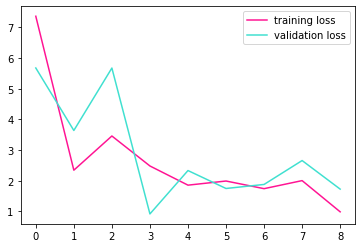

In [32]:
train_plot(modelCNN)

While accuracy was high, the network was clearly overfitting, and shows this isn't a good model

####CNN2-45

A two-layer 2D convolutional network, with batch normalisation. 

In [33]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [34]:
modelCNN = Sequential([
                       Conv2D(45, kernel_size=(3,3), input_shape = input_shape),
                       BatchNormalization(),
                       Dropout(0.2),
                       Conv2D(22, kernel_size=(3,3), activation = 'relu'),
                       BatchNormalization(),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 45)        450       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 45)       180       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 98, 98, 45)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 22)        8932      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 22)       88        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 202752)            0

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 2s 17ms/step - loss: 12.1176 - accuracy: 0.7425 - val_loss: 2.9651 - val_accuracy: 0.8733
Epoch 2/30
88/88 [==============================] - 1s 14ms/step - loss: 4.0972 - accuracy: 0.8614 - val_loss: 2.5476 - val_accuracy: 0.8950
Epoch 3/30
88/88 [==============================] - 1s 14ms/step - loss: 2.8142 - accuracy: 0.8675 - val_loss: 1.6990 - val_accuracy: 0.8933
Epoch 4/30
88/88 [==============================] - 1s 14ms/step - loss: 1.5812 - accuracy: 0.8786 - val_loss: 3.0553 - val_accuracy: 0.8117
Epoch 5/30
88/88 [==============================] - 1s 14ms/step - loss: 1.5195 - accuracy: 0.8725 - val_loss: 1.1281 - val_accuracy: 0.8417
Epoch 6/30
88/88 [==============================] - 1s 14ms/step - loss: 1.6259 - accuracy: 0.8793 - val_loss: 1.9909 - val_accuracy: 0.7800
Epoch 7/30
88/88 [==============================] - 1s 14ms/step - loss: 1.6821 - accuracy: 0.8761 - val_loss: 1.0247 - val_accuracy: 0.8717
Epoch 8/30
88/88 [=====

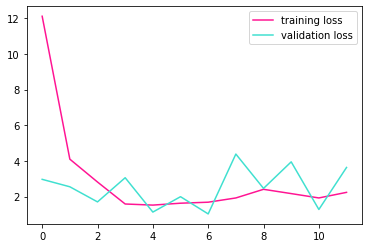

In [35]:
train_plot(modelCNN)

The model had good accuracy, but had a huge overfitting problem

####CNN1-20

In [36]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [37]:
modelCNN = Sequential([
                       Conv2D(20, kernel_size=(3,3), input_shape = input_shape),
                       BatchNormalization(),
                       MaxPooling2D(pool_size=(3,3)),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 20)        200       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 20)       80        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 20)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 4)                 81924     
                                                                 
Total params: 82,204
Trainable params: 82,164
Non-traina

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 1s 7ms/step - loss: 3.2367 - accuracy: 0.5582 - val_loss: 0.4964 - val_accuracy: 0.8900
Epoch 2/30
88/88 [==============================] - 0s 5ms/step - loss: 0.4120 - accuracy: 0.8682 - val_loss: 0.5974 - val_accuracy: 0.8117
Epoch 3/30
88/88 [==============================] - 0s 5ms/step - loss: 0.4893 - accuracy: 0.8650 - val_loss: 0.7038 - val_accuracy: 0.8767
Epoch 4/30
88/88 [==============================] - 0s 5ms/step - loss: 0.4722 - accuracy: 0.8657 - val_loss: 0.3031 - val_accuracy: 0.8933
Epoch 5/30
88/88 [==============================] - 0s 5ms/step - loss: 0.4885 - accuracy: 0.8596 - val_loss: 0.4839 - val_accuracy: 0.8517
Epoch 6/30
88/88 [==============================] - 0s 5ms/step - loss: 0.4340 - accuracy: 0.8721 - val_loss: 0.2335 - val_accuracy: 0.8483
Epoch 7/30
88/88 [==============================] - 0s 5ms/step - loss: 0.4707 - accuracy: 0.8739 - val_loss: 0.4892 - val_accuracy: 0.8733
Epoch 8/30
88/88 [=============

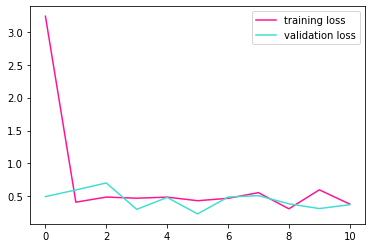

In [38]:
train_plot(modelCNN)

Once again, the model had excellent validation accuracy, but was overfitting the data.

####CNN4-128

#####Added maxpooling

#####First model without batch normalisation

In [39]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [40]:
modelCNN = Sequential([
                       Conv2D(128, kernel_size=(3,3), input_shape = input_shape),
                       Conv2D(64, kernel_size=(3,3)),
                       Dropout(0.2),
                       Conv2D(32, kernel_size=(3,3), activation='relu'),
                       Conv2D(16, kernel_size=(3,3)),
                       MaxPooling2D(pool_size=(3,3)),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        73792     
                                                                 
 dropout (Dropout)           (None, 96, 96, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                        

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 3s 32ms/step - loss: 10.0320 - accuracy: 0.2357 - val_loss: 1.3883 - val_accuracy: 0.2383
Epoch 2/30
88/88 [==============================] - 3s 30ms/step - loss: 1.3883 - accuracy: 0.2507 - val_loss: 1.3896 - val_accuracy: 0.2367
Epoch 3/30
88/88 [==============================] - 3s 30ms/step - loss: 1.3876 - accuracy: 0.2514 - val_loss: 1.3952 - val_accuracy: 0.2383
Epoch 4/30
88/88 [==============================] - 3s 30ms/step - loss: 1.3884 - accuracy: 0.2529 - val_loss: 1.3852 - val_accuracy: 0.2517
Epoch 5/30
88/88 [==============================] - 3s 30ms/step - loss: 1.3896 - accuracy: 0.2404 - val_loss: 1.3853 - val_accuracy: 0.2517
Epoch 6/30
88/88 [==============================] - 3s 30ms/step - loss: 1.3882 - accuracy: 0.2536 - val_loss: 1.3861 - val_accuracy: 0.2517
Epoch 7/30
88/88 [==============================] - 3s 30ms/step - loss: 1.3884 - accuracy: 0.2379 - val_loss: 1.3890 - val_accuracy: 0.2517
Epoch 8/30
88/88 [=====

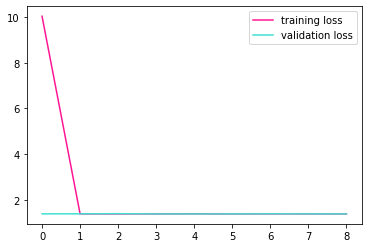

In [41]:
train_plot(modelCNN)

This model shows very poor accuracy, below 50%, so can be considered useless. 

#####Second model with batch normalisation. 

In [42]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

In [43]:
modelCNN = Sequential([
                       Conv2D(128, kernel_size=(3,3), input_shape = input_shape),
                       BatchNormalization(),
                       Conv2D(64, kernel_size=(3,3)),
                       BatchNormalization(),
                       Dropout(0.2),
                       Conv2D(32, kernel_size=(3,3), activation='relu'),
                       BatchNormalization(),
                       Conv2D(16, kernel_size=(3,3)),
                       BatchNormalization(),
                       MaxPooling2D(pool_size=(3,3)),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 96, 96, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        1

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 4s 39ms/step - loss: 2.5074 - accuracy: 0.4082 - val_loss: 3.1664 - val_accuracy: 0.2383
Epoch 2/30
88/88 [==============================] - 3s 37ms/step - loss: 0.4250 - accuracy: 0.8525 - val_loss: 0.6276 - val_accuracy: 0.7433
Epoch 3/30
88/88 [==============================] - 3s 37ms/step - loss: 0.3566 - accuracy: 0.8700 - val_loss: 0.3944 - val_accuracy: 0.8783
Epoch 4/30
88/88 [==============================] - 3s 37ms/step - loss: 0.3566 - accuracy: 0.8700 - val_loss: 0.2374 - val_accuracy: 0.8983
Epoch 5/30
88/88 [==============================] - 3s 36ms/step - loss: 0.3504 - accuracy: 0.8664 - val_loss: 0.5581 - val_accuracy: 0.8450
Epoch 6/30
88/88 [==============================] - 3s 36ms/step - loss: 0.3637 - accuracy: 0.8693 - val_loss: 0.2448 - val_accuracy: 0.8983
Epoch 7/30
88/88 [==============================] - 3s 37ms/step - loss: 0.3413 - accuracy: 0.8793 - val_loss: 0.3077 - val_accuracy: 0.8717
Epoch 8/30
88/88 [======

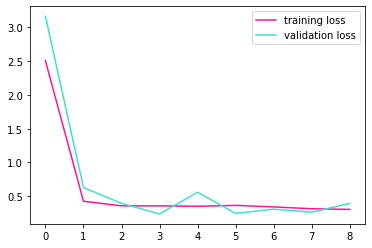

In [44]:
train_plot(modelCNN)

The batch normalisation helped the model significantly, while the model does not seem to be suffering an overfitting problem, the accuracy is poor compared to the first model, so that is selected as the final one. 

# Question 6


Compare the models you have created so far (both RNNs and CNNs) and make a 
selection (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set.

After attempting multiple different models, the original model from figure 12 was the one with the highest accuracy level, however the 4 layer CNN with 128 neurons, batch normalisation and max pooling was a close second. RNN networks were not considered due to their computationally intensive nature

Splitting into training and test sets, with a combined training and validation size. 

In [17]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(TimeSeries_combined_Q3, y_pickle2, train_size=0.85, random_state = 704)

In [18]:
X_train_final = X_train_final.astype('float32')
X_test_final = X_test_final.astype('float32')


In [19]:
y_train_final = tf.keras.utils.to_categorical(y_train_final, num_classes)

y_test_final = tf.keras.utils.to_categorical(y_test_final, num_classes)

Reshaping the test and training sets into a (100,100,1) image

In [20]:
if K.image_data_format() == 'channels_first':
  X_train_final = X_train_final.reshape(X_train_final.shape[0], img_channels, img_rows, img_cols)
  
  X_test_final = X_test_final.reshape(X_test_final.shape[0], img_channels, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
else:
  X_train_final = X_train_final.reshape(X_train_final.shape[0], img_rows, img_cols, img_channels)

  X_test_final = X_test_final.reshape(X_test_final.shape[0], img_rows, img_cols, img_channels)
  input_shape = (img_rows, img_cols, img_channels)

In [21]:
tf.keras.backend.clear_session()
np.random.seed(400)
tf.random.set_seed(830)

#####Defining the final Model

In [22]:
modelCNN_final = Sequential([
                       Conv2D(32, kernel_size=(3,3), input_shape = input_shape),
                       Conv2D(32, kernel_size=(3,3)),
                       Dropout(0.2),
                       Conv2D(16, kernel_size=(3,3), activation='relu'),
                       MaxPooling2D(pool_size=(3,3)),
                       Flatten(),
                       Dense(num_classes, activation = 'softmax')])
modelCNN_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                        

In [23]:
modelCNN_final.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=Adam(learning_rate = 0.001),metrics=["accuracy"])

#####Training the model

In [24]:
log = modelCNN_final.fit(X_train_final, y_train_final, epochs=25, validation_data=(X_test_final, y_test_final))

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


107/107 [==============================] - 2s 13ms/step - loss: 7.7046 - accuracy: 0.4126 - val_loss: 0.8197 - val_accuracy: 0.7100
Epoch 2/25
107/107 [==============================] - 1s 11ms/step - loss: 0.4210 - accuracy: 0.8426 - val_loss: 0.2546 - val_accuracy: 0.9017
Epoch 3/25
107/107 [==============================] - 1s 11ms/step - loss: 0.3014 - accuracy: 0.8762 - val_loss: 0.2381 - val_accuracy: 0.9017
Epoch 4/25
107/107 [==============================] - 1s 11ms/step - loss: 0.2774 - accuracy: 0.8800 - val_loss: 0.2483 - val_accuracy: 0.9017
Epoch 5/25
107/107 [==============================] - 1s 11ms/step - loss: 0.2644 - accuracy: 0.8841 - val_loss: 0.2376 - val_accuracy: 0.9017
Epoch 6/25
107/107 [==============================] - 1s 11ms/step - loss: 0.2570 - accuracy: 0.8785 - val_loss: 0.2428 - val_accuracy: 0.8900
Epoch 7/25
107/107 [==============================] - 1s 11ms/step - loss: 0.2694 - accuracy: 0.8768 - val_loss: 0.2363 - val_accuracy: 0.8983
Epoch 8/25

#####Plotting Graphs

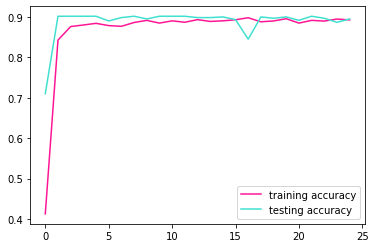

In [47]:
plt.plot(log.history['accuracy'],label = "training accuracy", color='deeppink')
plt.plot(log.history['val_accuracy'], label = "testing accuracy", color = 'turquoise')
plt.legend()
plt.show()

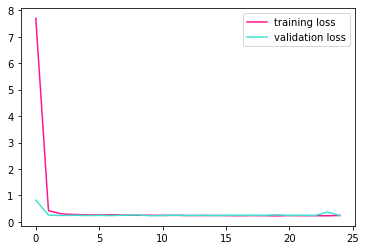

In [46]:
    plt.plot(log.history['loss'],label = "training loss",color='deeppink')
    plt.plot(log.history['val_loss'], label = "validation loss",color='turquoise')
    plt.legend()
    plt.show()

The model has been trained on the combined test and validation set, and shows good accuracy and no signs of overfitting. This trained model is evaluated below. 

In [48]:
modelCNN_final.evaluate(X_test_final,y_test_final)

19/19 [==============================] - 0s 4ms/step - loss: 0.2368 - accuracy: 0.8950


[0.23683840036392212, 0.8949999809265137]

The small loss and high accuracy of 89.5% makes this the model of choice, and is saved below. 

In [49]:
modelCNN_final.save('Mohanty_Aditya_Question_6.h5')

# Reference List


1.	Macnica. 2020. Convolutional Neural Network (CNN) for Time Series Classification - スマートファクトリー - マクニカ. [online] Available at: <https://www.macnica.co.jp/business/ai_iot/columns/135112/#:~:text=CNNs%20are%20computationally%20cheaper%20than,patterns%20within%20the%20time%20window.> [Accessed 11 April 2022].


2.	Rahimilarki, R., Gao, Z., Jin, N. and Zhang, A., 2022. Convolutional neural network fault classification based on time-series analysis for benchmark wind turbine machine. Renewable Energy, 185, pp.916-931.
